# Starbucks Capstone Challenge

## Project Overview

In today's customer-centric world, data is becoming more valuable as the insight it provides helps businesses understand details of its customer base. For example, the 360-degree view is the foundation that makes an organization's relationship with customers experiential rather than transactional — the key to long-standing customer relationships. It is the understanding that companies can obtain a comprehensive view of customers by leveraging data from various touchpoints in a customer’s journey.

This dataset contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. The objective is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

Every offer has a validity period before the offer expires. For example, a BOGO offer might be valid for only 5 days. In the dataset there are informational offers that have a validity period even though these ads are merely providing information about a product. For example, if an informational offer has 7 days of validity, the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Additionally, there is transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. There are cases where someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Problem Statement

I am interested in answering the following questions:
* Which offer should be sent to a particular customer to let the customer buy more?
* Which demographic groups respond best to which offer type?

The way in which I am aiming to answer the questions above is shown below:
* __Step 1:__ Install Python libraries and download/retrieve the datasets
* __Step 2:__ Pre-process offer portfolio, customer profile, and transaction data
* __Step 3:__ Combine pre-processed data to illustrate offer attributes, customer demographic, and transaction detail on a record basis
* __Step 4:__ Split the aggregated dataset into training/testing data
* __Step 5:__ Perform data analysis and visualizations for each offer type
* __Step 6:__ Train models and evaluate model performances 
    * Naive Classifier model (assumes all offers were successful)
    * Classification models (Logistic Regression, Random Forest, and Gradient Boosting)
* __Step 7:__ Tune best performing training model and evaluate model on test data

## Metrics

The metrics to quantify the performance of both the benchmark model (Naive Classifier) and the classification models will be the accuracy and the F1 score.

The accuracy measures the fraction of predictions that the model got right and is defined below:

$$Accuracy = \frac{Correct Predictions}{Total Predictions}$$

The F1 score is also a measure of a test’s accuracy except that it considers both the precision and the recall to compute the score. Prior to defining the F1 score however, I will need to define the precision and recall. 

Precision describes how precise the model is out of the predicted positive cases and is defined below: 

$$Precision = \frac{True Positive}{True Positive+False Positive}$$

Recall describes how many cases were actual positives through the model labeling it as positive and is defined below: 

$$Recall = \frac{True Positive}{True Positive + False Negative}$$

With the precision and recall definitions in mind, the F1 score metric can be interpreted as the weighted average of the precision and recall and is defined below:

$$F1 score = 2 x \frac{Precision*Recall}{Precision+Recall}$$


# Step 1: Install Python Libraries and Read Input Data

In [1]:
import pandas as pd
import numpy as np
from time import time, sleep
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from datetime import datetime
import os
import progressbar
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
% matplotlib inline

## Input Data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In each respective section are the schema and explanation of each variable for each file.


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step 2.0: Pre-Process Portfolio Data
Before beginning any pre-processing, I want to inspect what type of data I'm working with in the Portfolio dataset.

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## Observations
* The channels column is an array type column with multiple values. Split labels using MultiLabelBinarizer
* Rename columns to be more descriptive
* Convert offer_type into numeric using One Hot Encode

In [5]:
# Rename id, duration and difficulty columns to offer_id, duration_days, and min_spend_required respectively
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
portfolio.rename(columns={'duration': 'duration_days'}, inplace=True)
portfolio.rename(columns={'difficulty': 'min_spend_required'}, inplace=True)

# Rearrange columns
portfolio_column_ordering = ['offer_id', 'min_spend_required', 'reward', 'duration_days']

In [6]:
# Convert categorical variable into dummy/indicator variables.
offer_type_df = pd.get_dummies(portfolio['offer_type'])

# Convert channels column into multiple columns per label and numerically encode values
mlb = MultiLabelBinarizer()
channels_df = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_)
channels_df = channels_df.add_prefix('channels_')

# Concat original portfolio with rearrange columns, offer_type_df, and channels_df across the columns
portfolio = pd.concat([portfolio[portfolio_column_ordering], offer_type_df, channels_df], axis=1)
portfolio

,offer_id,min_spend_required,reward,duration_days,bogo,discount,informational,channels_email,channels_mobile,channels_social,channels_web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,1,0,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,0,1,0,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,0,1,0,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,1,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,10,2,7,0,1,0,1,1,0,1


# Step 2.1: Pre-Process Profile Data
Similar to the Portfolio dataset, I want to inspect what type of data I'm working with in the Profile dataset.

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [7]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
# Sort by descending order percentage of what customer membership distribution 
became_member_on = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
start_year = became_member_on.apply(lambda x: x.year).value_counts()
start_year *= 100 / start_year.sum()
round(start_year, 2)

2017    38.05
2018    24.69
2016    20.74
2015    10.76
2014     4.06
2013     1.68
Name: became_member_on, dtype: float64

In [10]:
# Sort by descending order percentage of gender distribution
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
round(gender_counts, 2)

M    57.23
F    41.34
O     1.43
Name: gender, dtype: float64

## Observations

* Around 13% of records have null gender and income; remove records with these missing data
* Records that have null gender and/or income have age as 118
* became_member_on is in format YYYYMMDD; convert column to datetime object
* Convert year from became_member_on via One Hot Encode
* 57.23% male, 41.34% female, 1.43% other for gender column; convert into dummy/indicator variable
* Bin customer's age into buckets

In [11]:
# Remove records where there is missing data and where gender = 'O'
# Reset index afterwards
profile = profile.dropna()
profile = profile.drop(profile[profile['gender'] == 'O'].index)
profile = profile.reset_index(drop=True)

In [12]:
# Convert became_member_on column to datetime and create temp customer_start_year column for dummy/indicator variable
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
profile['customer_start_year'] = profile['became_member_on'].apply(lambda x: x.year)
customer_start_year_df = pd.get_dummies(profile['customer_start_year'], prefix='start_year')
customer_start_year_df.head(10)

,start_year_2013,start_year_2014,start_year_2015,start_year_2016,start_year_2017,start_year_2018
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,1,0
5,0,0,0,0,1,0
6,0,1,0,0,0,0
7,0,0,0,1,0,0
8,0,1,0,0,0,0
9,0,0,0,0,1,0


In [13]:
# Inspect age column after removing null records
profile['age'].describe()

count    14613.000000
mean        54.393417
std         17.400201
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [14]:
# Inspect age bins based on deciles
pd.qcut(profile['age'], q=10, precision=2).unique()

[(51.0, 55.0], (69.0, 77.0], (64.0, 69.0], (55.0, 59.0], (59.0, 64.0], (17.99, 29.0], (46.0, 51.0], (39.0, 46.0], (77.0, 101.0], (29.0, 39.0]]
Categories (10, interval[float64]): [(17.99, 29.0] < (29.0, 39.0] < (39.0, 46.0] < (46.0, 51.0] ... (59.0, 64.0] < (64.0, 69.0] < (69.0, 77.0] < (77.0, 101.0]]

In [15]:
# One Hot Encode age_bin decile into columns
profile['age_bin'] = pd.qcut(profile['age'], q=10, precision=2)
profile['age_bin'] = profile['age_bin'].astype('str')
age_bin_df = pd.get_dummies(profile['age_bin'], prefix='age_bin')
age_bin_df.head(10)

,"age_bin_(17.99, 29.0]","age_bin_(29.0, 39.0]","age_bin_(39.0, 46.0]","age_bin_(46.0, 51.0]","age_bin_(51.0, 55.0]","age_bin_(55.0, 59.0]","age_bin_(59.0, 64.0]","age_bin_(64.0, 69.0]","age_bin_(69.0, 77.0]","age_bin_(77.0, 101.0]"
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0
6,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0
8,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0


In [16]:
# Create gender to int mapping
gender_int_mapping = {'F': 0, 'M': 1}
profile['gender_encoding'] = profile['gender'].map(gender_int_mapping)

# Concat original profile with rearranged columns, customer_start_year_df, and age_bin_df across the columns
profile_column_ordering = ['id', 'gender', 'gender_encoding', 'age_bin', 'income', 'customer_start_year']
profile = pd.concat([profile[profile_column_ordering], customer_start_year_df, age_bin_df], axis=1)
profile.head(10)

,id,gender,gender_encoding,age_bin,income,customer_start_year,start_year_2013,start_year_2014,start_year_2015,start_year_2016,...,"age_bin_(17.99, 29.0]","age_bin_(29.0, 39.0]","age_bin_(39.0, 46.0]","age_bin_(46.0, 51.0]","age_bin_(51.0, 55.0]","age_bin_(55.0, 59.0]","age_bin_(59.0, 64.0]","age_bin_(64.0, 69.0]","age_bin_(69.0, 77.0]","age_bin_(77.0, 101.0]"
0,0610b486422d4921ae7d2bf64640c50b,F,0,"(51.0, 55.0]",112000.0,2017,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,F,0,"(69.0, 77.0]",100000.0,2017,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,M,1,"(64.0, 69.0]",70000.0,2018,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,389bc3fa690240e798340f5a15918d5c,M,1,"(64.0, 69.0]",53000.0,2018,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,M,1,"(55.0, 59.0]",51000.0,2017,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,aa4862eba776480b8bb9c68455b8c2e1,F,0,"(59.0, 64.0]",57000.0,2017,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,e12aeaf2d47d42479ea1c4ac3d8286c6,M,1,"(17.99, 29.0]",46000.0,2014,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
7,31dda685af34476cad5bc968bdb01c53,F,0,"(59.0, 64.0]",71000.0,2016,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
8,62cf5e10845442329191fc246e7bcea3,M,1,"(46.0, 51.0]",52000.0,2014,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
9,6445de3b47274c759400cd68131d91b4,M,1,"(55.0, 59.0]",42000.0,2017,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Profile Data Visualizations

Text(0,0.5,'Count')

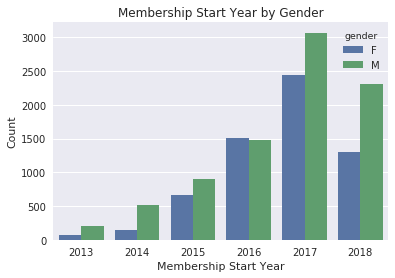

In [17]:
# Plot Membership Start Year by Gender
sns.set(style="darkgrid")
ax = sns.countplot(x="customer_start_year", hue="gender", data=profile)
ax.set_title('Membership Start Year by Gender')
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

Graph above illustrates that memberships increase over the years with 2017 showing the biggest rise. Additionally, male memberships are higher than female memberships for every year except 2016 where it's fairly even.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

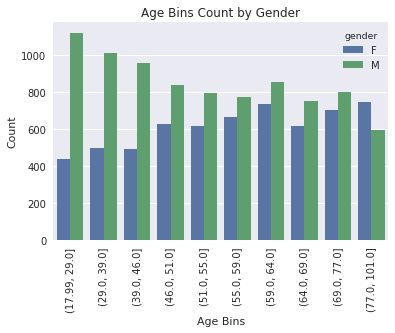

In [18]:
# Sort df by age_bin to get x-axis in correct order
profile_age_bin = profile.sort_values(by=['age_bin'])

# Plot categorical barplot 
ax = sns.countplot(x="age_bin", hue="gender", data=profile_age_bin, hue_order=['F', 'M'])
ax.set_title('Age Bins Count by Gender')
plt.xlabel('Age Bins')
plt.ylabel('Count')
plt.xticks(rotation=90)

Graph above illustrates general descending count as age bin increases. Similar to graph above, more males are accounted for than females per age bin except for age bin 77-101.

In [19]:
# Create two variables for raphs below
male_customers = profile_age_bin[profile_age_bin['gender'] == 'M']
female_customers = profile_age_bin[profile_age_bin['gender'] == 'F']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

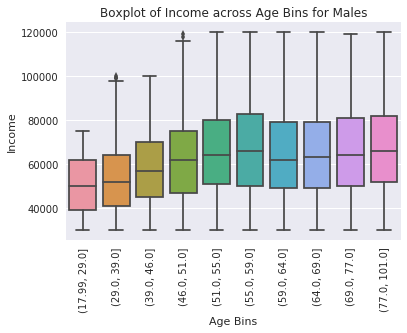

In [20]:
# Plot boxplot of income across age bins for males
ax = sns.boxplot(x="age_bin", y='income', data=male_customers)
ax.set_title('Boxplot of Income across Age Bins for Males')
plt.xlabel('Age Bins')
plt.ylabel('Income')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

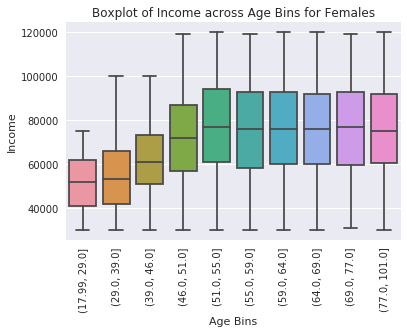

In [21]:
# Plot boxplot of income across age bins for females
ax = sns.boxplot(x="age_bin", y='income', data=female_customers)
ax.set_title('Boxplot of Income across Age Bins for Females')
plt.xlabel('Age Bins')
plt.ylabel('Income')
plt.xticks(rotation=90)

Income for both male and female generally increases as age bin is increased. Additionally, the median female income is higher than the median male income, especially from age bin 46-51 and onward.

# Step 2.2: Pre-Process Transcript Data
Similar to the Portfolio and Profile dataset, I want to inspect what type of data I'm working with in the Transcript dataset.

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [22]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
# Get unique value and counts for event column
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [25]:
# Get unique values for time column
transcript['time'].unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [26]:
# Get unique dict keys for value column
transcript['value'].apply(lambda elem: list(elem.keys())[0]).unique()

array(['offer id', 'amount', 'offer_id'], dtype=object)

## Observations
* Need to split transaction records associated with 'amount' from offer records associated with 'offer id' in __value__ column
* Remove __person__ ids not in profile dataframe and rename column to __profile_id__
* Convert __time__ column from hours to days 

In [27]:
# Create transcript df that contains transcript person ids from the profile df's id column
filtered_transcript_df = transcript['person'].isin(profile['id'])
transcript = transcript[filtered_transcript_df]
transcript.rename(columns={'person': 'profile_id'}, inplace=True)
transcript.head(10)

,event,profile_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15,offer received,f806632c011441378d4646567f357a21,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [28]:
# Convert time column to days and rename column
transcript['time'] /= 24.0
transcript.rename(columns={'time': 'days'}, inplace=True)
transcript['days'].unique()

array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ,  10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,
        12.  ,  12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,
        14.  ,  14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,
        16.  ,  16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,
        18.  ,  18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,
        20.  ,  20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,
        22.  ,  22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,
        24.  ,  24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,
        26.  ,  26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75,
      

In [29]:
# Create offer_df with 'offer' only events from transcript df
# Create offer_types_df with One Hot Encode of offer_df's event column 
offer_df = transcript[transcript['event'].str.contains('offer',case=False)]
offer_df.reset_index(drop=True)
offer_df['event'] = offer_df['event'].apply(lambda x: x.replace(" ", "_"))
offer_types_df = pd.get_dummies(offer_df['event'])
offer_types_df.reset_index(drop=True)
offer_types_df.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,offer_completed,offer_received,offer_viewed
0,0,1,0
2,0,1,0
5,0,1,0
7,0,1,0
8,0,1,0
9,0,1,0
12,0,1,0
13,0,1,0
14,0,1,0
15,0,1,0


In [30]:
# Retrieve dict value from offer_df's value column and combine offer df and offer_types df
offer_df['offer_id'] = offer_df['value'].apply(lambda elem: list(elem.values())[0])
offer_column_ordering = ['offer_id', 'profile_id', 'days', 'offer_completed', 'offer_received', 'offer_viewed']
offer_df = pd.concat([offer_df, offer_types_df], axis=1)
offer_df = offer_df[offer_column_ordering]
offer_df.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,offer_id,profile_id,days,offer_completed,offer_received,offer_viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
5,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
7,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c53,0.0,0,1,0
12,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0,1,0
13,3f207df678b143eea3cee63160fa8bed,c27e0d6ab72c455a8bb66d980963de60,0.0,0,1,0
14,0b1e1539f2cc45b7b9fa7c272da2e1d7,d53717f5400c4e84affdaeda9dd926b3,0.0,0,1,0
15,fafdcd668e3743c1bb461111dcafc2a4,f806632c011441378d4646567f357a21,0.0,0,1,0


In [31]:
# Create transaction_df of transcript records whose event column contains 'transaction'
transaction_df = transcript[transcript['event'].str.contains('transaction',case=False)]
transaction_df.reset_index(drop=True)
transaction_df.head(10)

,event,profile_id,days,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97}
12678,transaction,629fc02d56414d91bca360decdfa9288,0.0,{'amount': 33.9}
12687,transaction,a97e6f33219c432db82acfa0d19c602d,0.0,{'amount': 18.59}
12691,transaction,676506bad68e4161b9bbaffeb039626b,0.0,{'amount': 18.01}
12696,transaction,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,{'amount': 19.11}
12706,transaction,4cbe33c601a5407f8202086565c55111,0.0,{'amount': 36.19}


In [32]:
# Retrieve dict value from transaction_df's value column to create amount column
transaction_df['amount'] = transaction_df['value'].apply(lambda elem: list(elem.values())[0])
transaction_column_ordering = ['profile_id', 'days', 'amount']
transaction_df = transaction_df[transaction_column_ordering]
transaction_df.head(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,profile_id,days,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97
12678,629fc02d56414d91bca360decdfa9288,0.0,33.90
12687,a97e6f33219c432db82acfa0d19c602d,0.0,18.59
12691,676506bad68e4161b9bbaffeb039626b,0.0,18.01
12696,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,19.11
12706,4cbe33c601a5407f8202086565c55111,0.0,36.19


# Step 3: Combine Portfolio, Profile, Offer and Transaction Datasets

In [33]:
def aggregate_datasets(profile_id, portfolio, profile, offer_df, transaction_df):
    # Select a customer's profile
    current_customer = profile.loc[profile['id'] == profile_id]

    # Select offer data for specific customer
    current_customer_offer_data = offer_df.loc[offer_df['profile_id'] == profile_id]
    current_customer_offer_data = current_customer_offer_data.drop(columns='profile_id').reset_index(drop=True)

    # Select transaction data for specific customer
    current_customer_transaction_data = transaction_df.loc[transaction_df['profile_id'] == profile_id]
    current_customer_transaction_data = current_customer_transaction_data.drop(columns='profile_id').reset_index(drop=True)

    # Create dataframes for when a customer receives, views, and completes an offer
    event_type = ['offer_completed', 'offer_received', 'offer_viewed']

    offer_received = current_customer_offer_data.loc[current_customer_offer_data['offer_received'] == 1]
    offer_received = offer_received.drop(columns=event_type).reset_index(drop=True)

    offer_viewed = current_customer_offer_data.loc[current_customer_offer_data['offer_viewed'] == 1]
    offer_viewed = offer_viewed.drop(columns=event_type).reset_index(drop=True)

    offer_completed = current_customer_offer_data.loc[current_customer_offer_data['offer_completed'] == 1]
    offer_completed = offer_completed.drop(columns=event_type).reset_index(drop=True)
    
    rows = []
    for i in range(offer_received.shape[0]):

        # Select the current offer id
        current_offer_id = offer_received.iloc[i]['offer_id']

        # Find description for current offer
        current_offer = portfolio.loc[portfolio['offer_id'] == current_offer_id]
        days = current_offer['duration_days'].values[0]

        # Identify time period for when offer is valid
        current_offer_startime = offer_received.iloc[i]['days']
        current_offer_endtime = offer_received.iloc[i]['days'] + days

        # Create boolean array that selects customer transcations within valid offer time window
        select_transaction = np.logical_and(current_customer_transaction_data['days'] >= current_offer_startime,
                                            current_customer_transaction_data['days'] <= current_offer_endtime)

        # Create boolean array that selects description for when a customer completes an offer
        select_offer_completed = np.logical_and(offer_completed['days'] >= current_offer_startime,
                                                offer_completed['days'] <= current_offer_endtime)

        # Initialize a boolean array that selects a description of when a customer views an offer
        select_offer_viewed = np.logical_and(offer_viewed['days'] >= current_offer_startime,
                                             offer_viewed['days'] <= current_offer_endtime)

        # Determine if current offer was successful
        current_offer_successful = select_offer_completed.sum() > 0 # and select_offer_viewed.sum() > 0

        # Identify customer transcations that occurred within current offer valid time window
        current_offer_transactions = current_customer_transaction_data[select_transaction]

        # Create dictionary that describes the current customer offer
        current_row = {'offer_id': current_offer_id,
                       'profile_id': profile_id,
                       'time': current_offer_startime,
                       'offer_successful': int(current_offer_successful),
                       'total_amount': current_offer_transactions['amount'].sum()}

        current_row.update(current_offer.iloc[0, 1:].to_dict())
        current_row.update(current_customer.iloc[0, 1:].to_dict())

        # Add additional offers for customer if shown
        rows.append(current_row)

    return rows

In [34]:
clean_data_csv = "./data/clean_data.csv"

# If clean_data_csv file already exists; otherwise create the csv file
if os.path.exists(clean_data_csv):
    clean_data = pd.read_csv(clean_data_csv)
else:
    clean_data = []
    profile_id_list = offer_df['profile_id'].unique()

    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # Loop through each profile id across the various datasets
    for i in progressbar.progressbar(range(len(profile_id_list)), widgets=widgets):
        clean_data.extend(aggregate_datasets(profile_id_list[i], portfolio, profile, offer_df, transaction_df))
        sleep(0.01)

    # Create clean_data dataframe
    clean_data = pd.DataFrame(clean_data)
    column_ordering = ['time', 'offer_id', 'profile_id', 'total_amount',
                       'offer_successful', 'min_spend_required', 'duration_days',
                       'reward', 'bogo', 'discount', 'informational',
                       'channels_email', 'channels_mobile', 'channels_social', 'channels_web', 'gender_encoding',
                       'income', 'start_year_2013', 'start_year_2014', 'start_year_2015', 'start_year_2016',
                       'start_year_2017', 'start_year_2018', 'age_bin_(17.99, 29.0]', 'age_bin_(29.0, 39.0]',
                       'age_bin_(39.0, 46.0]', 'age_bin_(46.0, 51.0]', 'age_bin_(51.0, 55.0]',
                       'age_bin_(55.0, 59.0]', 'age_bin_(59.0, 64.0]', 'age_bin_(64.0, 69.0]',
                       'age_bin_(69.0, 77.0]', 'age_bin_(77.0, 101.0]']
    clean_data = clean_data[column_ordering].sort_values('time').reset_index(drop=True)
    clean_data.to_csv(clean_data_csv, index=False)

# Inspect clean_data df    
clean_data.head(10)

,time,offer_id,profile_id,total_amount,offer_successful,min_spend_required,duration_days,reward,bogo,discount,...,"age_bin_(17.99, 29.0]","age_bin_(29.0, 39.0]","age_bin_(39.0, 46.0]","age_bin_(46.0, 51.0]","age_bin_(51.0, 55.0]","age_bin_(55.0, 59.0]","age_bin_(59.0, 64.0]","age_bin_(64.0, 69.0]","age_bin_(69.0, 77.0]","age_bin_(77.0, 101.0]"
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,ff7cb44e72db4112b270560686f97a23,48.31,1,10,5,10,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,5a8bc65990b245e5a138643cd4eb9837,97b6993c232946d3b6b9f90530ff8073,23.43,0,0,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,81848348d5584aef9e7374a07ebe6ea1,52.24,1,5,7,5,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,fafdcd668e3743c1bb461111dcafc2a4,28f9666945804ab0bfc63f3ec6ae9af1,5.12,0,10,10,2,0,1,...,0,1,0,0,0,0,0,0,0,0
5,0.0,3f207df678b143eea3cee63160fa8bed,5180d955d076408dac0e7a3004756889,9.99,0,0,4,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,e4d95c80a1914492aff749a61bee8380,0.00,0,10,5,10,1,0,...,0,0,0,0,0,0,1,0,0,0
7,0.0,f19421c1d4aa40978ebb69ca19b0e20d,47621e81a9bc41459044c0ed409dfa9e,6.05,0,5,5,5,1,0,...,0,0,0,0,0,0,1,0,0,0
8,0.0,2906b810c7d4411798c6938adc9daaa5,f726eb45d69845b9b5b8100d074c64f7,47.78,1,10,7,2,0,1,...,0,0,0,1,0,0,0,0,0,0
9,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,331597393f414b0285918854d8ac292a,0.00,0,5,7,5,1,0,...,0,0,0,0,0,0,0,0,1,0


# Step 4: Split Data into Training/Testing Data

A key component to building a machine learning model is to split the data into training and testing data. The training data, which normally encompasses 80% of the data, contains a known output and the model learns on this data in order to be generalized to other data. The test data, which encompasses the remaining 20% of the data, is used to test the model's prediction performance.

In [35]:
# Setup train_test_split parameters and create train, test sets
x = clean_data.loc[:, clean_data.columns != 'offer_successful']
y = clean_data['offer_successful']
X_train, X_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2, random_state = 42)

# Change X_train, X_test columns to float
offer_id_train = X_train[:, 1]
X_train = X_train[:, 4:].astype('float64')

offer_id_test = X_test[:, 1]
X_test = X_test[:, 4:].astype('float64')

# Check dimensions of train and test datasets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52468, 28) (52468,)
(13117, 28) (13117,)


In [36]:
column_ordering = ['min_spend_required', 'duration_days', 'reward', 'bogo', 'discount', 'informational', 
                   'channels_email', 'channels_mobile', 'channels_social', 'channels_web',
                   'gender_encoding', 'income', 'start_year_2013', 'start_year_2014',
                   'start_year_2015', 'start_year_2016', 'start_year_2017',
                   'start_year_2018', 'age_bin_(17.99, 29.0]', 'age_bin_(29.0, 39.0]',
                   'age_bin_(39.0, 46.0]', 'age_bin_(46.0, 51.0]', 'age_bin_(51.0, 55.0]',
                   'age_bin_(55.0, 59.0]', 'age_bin_(59.0, 64.0]', 'age_bin_(64.0, 69.0]',
                   'age_bin_(69.0, 77.0]', 'age_bin_(77.0, 101.0]']

# Create sub dfs of training data in order to create final training_data df
training_features = pd.DataFrame(X_train, columns=column_ordering)
training_labels = pd.DataFrame(y_train, columns=['offer_successful'])
training_offer_id = pd.DataFrame(offer_id_train, columns=['offer_id'])

training_data = pd.concat([training_offer_id, training_features, training_labels], axis=1)
training_data = training_data.drop(columns=['min_spend_required', 'duration_days', 'reward', 'bogo', 'discount',
                                            'channels_mobile', 'channels_social', 'channels_web', 'channels_email',
                                            'informational'])
training_data.head(10)

,offer_id,gender_encoding,income,start_year_2013,start_year_2014,start_year_2015,start_year_2016,start_year_2017,start_year_2018,"age_bin_(17.99, 29.0]","age_bin_(29.0, 39.0]","age_bin_(39.0, 46.0]","age_bin_(46.0, 51.0]","age_bin_(51.0, 55.0]","age_bin_(55.0, 59.0]","age_bin_(59.0, 64.0]","age_bin_(64.0, 69.0]","age_bin_(69.0, 77.0]","age_bin_(77.0, 101.0]",offer_successful
0,fafdcd668e3743c1bb461111dcafc2a4,1.0,80000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,87000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,115000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,2906b810c7d4411798c6938adc9daaa5,0.0,115000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,1.0,31000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,3f207df678b143eea3cee63160fa8bed,0.0,66000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,71000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,52000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
8,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,51000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
9,ae264e3637204a6fb9bb56bc8210ddfd,1.0,34000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


## Analyze the Success of Each Offer Type

In [37]:
# Get how many offers were successful for each offer_id
successful_offer_counts = training_data[['offer_id', 'offer_successful']].groupby(['offer_id']).sum().reset_index()
successful_offer_counts.sort_values('offer_id')

,offer_id,offer_successful
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3014
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3886
2,2906b810c7d4411798c6938adc9daaa5,3155
3,3f207df678b143eea3cee63160fa8bed,587
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2761
5,5a8bc65990b245e5a138643cd4eb9837,394
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,3280
7,ae264e3637204a6fb9bb56bc8210ddfd,3062
8,f19421c1d4aa40978ebb69ca19b0e20d,3251
9,fafdcd668e3743c1bb461111dcafc2a4,3976


In [38]:
# Get how many total offers were sent for each offer_id
offer_counts = training_data['offer_id'].value_counts()
offer_counts = pd.DataFrame(list(zip(offer_counts.index.values, offer_counts.values)), columns=['offer_id', 'total'])
offer_counts.sort_values('offer_id')

,offer_id,total
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5337
3,2298d6c36e964ae4a3e7e9706d1fb8c2,5267
4,2906b810c7d4411798c6938adc9daaa5,5237
1,3f207df678b143eea3cee63160fa8bed,5298
8,4d5c57ea9a6940dd891ad53e9dbe8da0,5197
7,5a8bc65990b245e5a138643cd4eb9837,5221
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5236
2,ae264e3637204a6fb9bb56bc8210ddfd,5269
9,f19421c1d4aa40978ebb69ca19b0e20d,5183
6,fafdcd668e3743c1bb461111dcafc2a4,5223


In [39]:
# Merge successful_offer_counts df and offer_counts df called offer_id_success_rates
# to calculate percentage_success column
offer_id_success_rates = pd.merge(successful_offer_counts, offer_counts, on='offer_id')
offer_id_success_rates['percentage_success'] = round((100 * offer_id_success_rates['offer_successful'] / offer_id_success_rates['total']), 2)

# Merge offer_id_success_rates df and portfolio df to get full picture of portfolio
offer_id_success_rates = pd.merge(offer_id_success_rates, portfolio, on='offer_id')
offer_id_success_rates = offer_id_success_rates.sort_values('percentage_success', ascending=False).reset_index(drop=True)
offer_id_success_rates

,offer_id,offer_successful,total,percentage_success,min_spend_required,reward,duration_days,bogo,discount,informational,channels_email,channels_mobile,channels_social,channels_web
0,fafdcd668e3743c1bb461111dcafc2a4,3976,5223,76.12,10,2,10,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3886,5267,73.78,7,3,7,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,3251,5183,62.72,5,5,5,1,0,0,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3280,5236,62.64,5,5,7,1,0,0,1,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,3155,5237,60.24,10,2,7,0,1,0,1,1,0,1
5,ae264e3637204a6fb9bb56bc8210ddfd,3062,5269,58.11,10,10,7,1,0,0,1,1,1,0
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,3014,5337,56.47,20,5,10,0,1,0,1,0,0,1
7,4d5c57ea9a6940dd891ad53e9dbe8da0,2761,5197,53.13,10,10,5,1,0,0,1,1,1,1
8,3f207df678b143eea3cee63160fa8bed,587,5298,11.08,0,0,4,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,394,5221,7.55,0,0,3,0,0,1,1,1,1,0


Text(0,0.5,'Count')

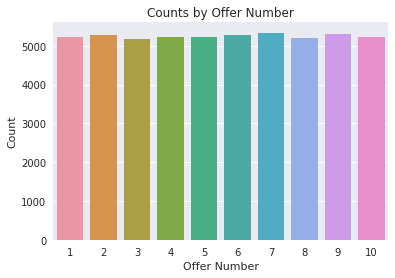

In [40]:
# Plot Counts by Offer Number 
ax = sns.barplot(x=offer_id_success_rates.index+1, y='total', data=offer_id_success_rates)
plt.title('Counts by Offer Number')
plt.xlabel('Offer Number')
plt.ylabel('Count')

Text(0,0.5,'Percent Success')

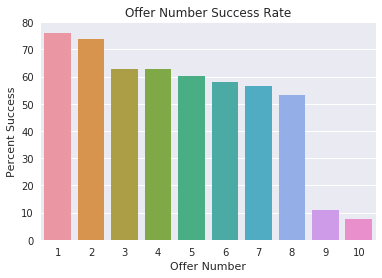

In [41]:
# Plot Success Rates of Offer Numbers
ax = sns.barplot(x=offer_id_success_rates.index+1, y='percentage_success', data=offer_id_success_rates)
plt.title('Offer Number Success Rate')
plt.xlabel('Offer Number')
plt.ylabel('Percent Success')

# Step 4.1: Feature Scaling
Feature Scaling is a technique used to standardize independent features to handle highly varying magnitudes. This is an important step as if it is avoided, a machine learning algorithm will tend to weigh greater values as higher and smaller values as lower.

In [42]:
feature_scaling_variables = ['min_spend_required', 'duration_days', 'reward', 'income']
min_max_scaler = {}

# Loop through feature scaling variables to apply MinMaxScaler()
for idx in range(len(feature_scaling_variables)):
    # Setup MinMaxScaler() 
    column_idx = np.argwhere(x.columns == feature_scaling_variables[idx])[0, 0]
    current_column = feature_scaling_variables[idx]
    min_max_scaler[current_column] = MinMaxScaler()

    # Fit and transform training data of feature_scaling_variables 
    train_transformed_values = min_max_scaler[current_column].fit_transform(X_train[:, column_idx].reshape(-1, 1))
    X_train[:, column_idx] = train_transformed_values.reshape(1, -1)
    
    # Fit and transform test data of feature_scaling_variables 
    test_transformed_values = min_max_scaler[current_column].fit_transform(X_test[:, column_idx].reshape(-1, 1))
    X_test[:, column_idx] = test_transformed_values.reshape(1, -1)


# Step 5: Offer IDs Analysis & Data Visualizations

## Reverse One Hot Encoding for Membership Start Year, Age Bins and Gender

In [43]:
def customer_offer_analytics(offer_id, offer_id_success_rates, training_data):
    # Retrieve current offer id and training data containing that offer id
    current_offer_id_row = offer_id_success_rates.iloc[offer_id-1]
    current_offer_id = offer_id_success_rates.iloc[offer_id-1]['offer_id']
    current_offer_data = training_data[training_data['offer_id'] == current_offer_id].copy()

    # Create dataframe for successful offers and unsuccessful offers
    offer_successful = current_offer_data['offer_successful'].astype('bool') 
    successful_offer = current_offer_data[offer_successful == True].copy() 
    unsuccessful_offer = current_offer_data[offer_successful == False].copy() 

    #############################
    ###### Membership_year ######
    #############################

    # Reverse one hot encode for start_year columns
    start_year_list = ['start_year_2013', 'start_year_2014', 'start_year_2015', 
                       'start_year_2016', 'start_year_2017', 'start_year_2018']

    start_year_cols = successful_offer.columns.values[3:9]

    # Successful offer reverse one hot encoding
    successful_reverse_ohe = pd.DataFrame(np.repeat(start_year_cols[None, :], len(successful_offer[start_year_cols]), 0)
                                          [successful_offer[start_year_cols].astype(bool).values], 
                                          successful_offer[start_year_cols].index[successful_offer[start_year_cols].any(1)])

    successful_reverse_ohe = successful_reverse_ohe.iloc[:, 0].str.replace('start_year_', '')

    # Unsuccessful offer reverse one hot encoding
    unsuccessful_reverse_ohe = pd.DataFrame(np.repeat(start_year_cols[None, :], len(unsuccessful_offer[start_year_cols]), 0)
                                          [unsuccessful_offer[start_year_cols].astype(bool).values], 
                                          unsuccessful_offer[start_year_cols].index[unsuccessful_offer[start_year_cols].any(1)])

    unsuccessful_reverse_ohe = unsuccessful_reverse_ohe.iloc[:, 0].str.replace('start_year_', '')

    successful_offer['membership_start_year'] = successful_reverse_ohe
    successful_offer = successful_offer.drop(columns=start_year_list)
    unsuccessful_offer['membership_start_year'] = unsuccessful_reverse_ohe
    unsuccessful_offer = unsuccessful_offer.drop(columns=start_year_list)

    #####################
    ###### Age_bin ######
    #####################

    # Reverse one hot encode for age_bin columns
    age_bin_list = ['age_bin_(17.99, 29.0]', 'age_bin_(29.0, 39.0]', 'age_bin_(39.0, 46.0]', 'age_bin_(46.0, 51.0]', 
                    'age_bin_(51.0, 55.0]', 'age_bin_(55.0, 59.0]', 'age_bin_(59.0, 64.0]', 'age_bin_(64.0, 69.0]', 
                    'age_bin_(69.0, 77.0]', 'age_bin_(77.0, 101.0]']

    age_bin_cols = successful_offer.columns.values[3:13]

    # Successful offer reverse one hot encoding
    successful_reverse_ohe = pd.DataFrame(np.repeat(age_bin_cols[None, :], len(successful_offer[age_bin_cols]), 0)
                                          [successful_offer[age_bin_cols].astype(bool).values], 
                                          successful_offer[age_bin_cols].index[successful_offer[age_bin_cols].any(1)])

    successful_reverse_ohe = successful_reverse_ohe.iloc[:, 0].str.replace('age_bin_', '')

    # Unsuccessful offer reverse one hot encoding
    unsuccessful_reverse_ohe = pd.DataFrame(np.repeat(age_bin_cols[None, :], len(unsuccessful_offer[age_bin_cols]), 0)
                                          [unsuccessful_offer[age_bin_cols].astype(bool).values], 
                                          unsuccessful_offer[age_bin_cols].index[unsuccessful_offer[age_bin_cols].any(1)])

    unsuccessful_reverse_ohe = unsuccessful_reverse_ohe.iloc[:, 0].str.replace('age_bin_', '')

    successful_offer['age_bin'] = successful_reverse_ohe
    successful_offer = successful_offer.drop(columns=age_bin_list)
    unsuccessful_offer['age_bin'] = unsuccessful_reverse_ohe
    unsuccessful_offer = unsuccessful_offer.drop(columns=age_bin_list)

    ####################
    ###### Gender ######
    ####################

    int_gender_mapping = {0: 'Female', 1: 'Male'}

    # Successful offer integer to gender mapping
    successful_offer['gender_encoding'] = successful_offer['gender_encoding'].map(int_gender_mapping)
    successful_offer.rename(columns={'gender_encoding': 'gender'}, inplace=True)
    successful_offer = successful_offer.reset_index(drop=True)

    # Unsuccessful offer integer to gender mapping
    unsuccessful_offer['gender_encoding'] = unsuccessful_offer['gender_encoding'].map(int_gender_mapping)
    unsuccessful_offer.rename(columns={'gender_encoding': 'gender'}, inplace=True)
    unsuccessful_offer = unsuccessful_offer.reset_index(drop=True)
    
    # Setup Visuals
    customer_income_visual = customer_income_visual_prep(successful_offer, unsuccessful_offer)
    customer_gender_visual = customer_gender_visual_prep(successful_offer, unsuccessful_offer)
    customer_age_bin_visual = customer_age_bin_visual_prep(successful_offer, unsuccessful_offer)
    customer_membership_start_year_visual = customer_membership_start_year_visual_prep(successful_offer, 
                                                                                       unsuccessful_offer)
    # Combine visualizations of 4 visuals above
    customer_offer_visualizations = combined_visualizations(current_offer_id,
                                                            customer_income_visual, 
                                                            customer_gender_visual, 
                                                            customer_age_bin_visual, 
                                                            customer_membership_start_year_visual)
    
    print(current_offer_id_row)
    return customer_offer_visualizations


## Customer Income Visual Preparation

In [44]:
def customer_income_visual_prep(successful_offer, unsuccessful_offer):
    # Setup histogram properties
    min_income = np.min([successful_offer['income'].min(), unsuccessful_offer['income'].min()]) #$30,000
    max_income = np.max([successful_offer['income'].max(), unsuccessful_offer['income'].max()]) #$120,000
    income_bins = np.linspace(min_income-1000, max_income+1000, 40)
    column_names = ['income', 'probability', 'successful']

    # Successful offer income histogram & dataframe
    income_histogram = np.histogram(successful_offer['income'], income_bins, density=True)[0]
    successful_offer_income = pd.DataFrame(list(zip(income_bins, income_histogram, np.repeat('Yes', 40))),
                                           columns=column_names)

    # Unsuccessful offer income histogram & dataframe
    income_histogram = np.histogram(unsuccessful_offer['income'], income_bins, density=True)[0]
    unsuccessful_offer_income = pd.DataFrame(list(zip(income_bins, income_histogram, np.repeat('No', 40))),
                                             columns=column_names)

    # Combine successful offer and unsuccessful offer dataframes
    customer_income = pd.concat([successful_offer_income, unsuccessful_offer_income], axis=0)
    customer_income.reset_index(drop=True)
    
    return customer_income

## Customer Gender Visual Preparation

In [45]:
def customer_gender_visual_prep(successful_offer, unsuccessful_offer):
    column_names = ['gender', 'percentage', 'successful']

    # Successful offer gender histogram & dataframe
    gender_histogram = successful_offer['gender'].value_counts()
    gender_histogram *= 100 / gender_histogram.sum()

    successful_offer_gender = pd.DataFrame(list(zip(gender_histogram.index.values, gender_histogram, np.repeat('Yes', 2))), 
                                           columns=column_names)

    # Unsuccessful offer gender histogram & dataframe
    gender_histogram = unsuccessful_offer['gender'].value_counts()
    gender_histogram *= 100 / gender_histogram.sum()

    unsuccessful_offer_gender = pd.DataFrame(list(zip(gender_histogram.index.values, gender_histogram, np.repeat('No', 2))), 
                                             columns=column_names)

    # Combine successful offer and unsuccessful offer dataframes
    customer_gender = pd.concat([successful_offer_gender, unsuccessful_offer_gender], axis=0)
    customer_gender.reset_index(drop=True)
    
    return customer_gender

## Customer Age Bin Visual Preparation

In [46]:
def customer_age_bin_visual_prep(successful_offer, unsuccessful_offer):
    column_names = ['age_bin', 'percentage', 'successful']

    # Successful offer age bin histogram & dataframe
    age_bin_histogram = successful_offer['age_bin'].value_counts()
    age_bin_histogram *= 100 / age_bin_histogram.sum()

    successful_offer_age_bin = pd.DataFrame(list(zip(age_bin_histogram.index.values, age_bin_histogram, np.repeat('Yes', 10))), 
                                           columns=column_names)

    # Unsuccessful offer age bin histogram & dataframe
    age_bin_histogram = unsuccessful_offer['age_bin'].value_counts()
    age_bin_histogram *= 100 / age_bin_histogram.sum()

    unsuccessful_offer_age_bin = pd.DataFrame(list(zip(age_bin_histogram.index.values, age_bin_histogram, np.repeat('No', 10))), 
                                             columns=column_names)

    # Combine successful offer and unsuccessful offer dataframes
    customer_age_bin = pd.concat([successful_offer_age_bin, unsuccessful_offer_age_bin], axis=0)

    custom_dict = {'(17.99, 29.0]':0, '(29.0, 39.0]':1, '(39.0, 46.0]':2, '(46.0, 51.0]':3, '(51.0, 55.0]':4, 
                   '(55.0, 59.0]':5, '(59.0, 64.0]':6, '(64.0, 69.0]':7, '(69.0, 77.0]':8, '(77.0, 101.0]':9}

    customer_age_bin['sort'] = customer_age_bin['age_bin'].map(custom_dict)
    customer_age_bin.sort_values('sort', inplace=True)
    customer_age_bin.reset_index(drop=True)
    
    return customer_age_bin

## Membership Start Year Visual Preparation

In [47]:
def customer_membership_start_year_visual_prep(successful_offer, unsuccessful_offer):
    column_names = ['membership_start_year', 'percentage', 'successful']

    # Successful offer membership_start_year histogram & dataframe
    membership_start_year_histogram = successful_offer['membership_start_year'].value_counts()
    membership_start_year_histogram *= 100 / membership_start_year_histogram.sum()

    successful_offer_membership_start_year = pd.DataFrame(list(zip(membership_start_year_histogram.index.values, 
                                                                   membership_start_year_histogram, np.repeat('Yes', 6))), 
                                                          columns=column_names)

    # Unsuccessful offer membership_start_year histogram & dataframe
    membership_start_year_histogram = unsuccessful_offer['membership_start_year'].value_counts()
    membership_start_year_histogram *= 100 / membership_start_year_histogram.sum()

    unsuccessful_offer_membership_start_year = pd.DataFrame(list(zip(membership_start_year_histogram.index.values, 
                                                                     membership_start_year_histogram, np.repeat('No', 6))), 
                                                            columns=column_names)

    # Combine successful offer and unsuccessful offer dataframes
    customer_membership_start_year = pd.concat([successful_offer_membership_start_year, 
                                                unsuccessful_offer_membership_start_year], axis=0)
    customer_membership_start_year.sort_values('membership_start_year', inplace=True)
    customer_membership_start_year.reset_index(drop=True)
    
    return customer_membership_start_year

## Combine Visualizations

In [48]:
def combined_visualizations(offer_id, 
                            customer_income_visual, 
                            customer_gender_visual, 
                            customer_age_bin_visual, 
                            customer_membership_start_year_visual):
    
    # Setup 4x1 Plot
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 14))
    
    # Customer Income Graph
    income_bins = customer_income_visual['income'].unique()

    xticks = np.array(np.arange(0, len(income_bins), 5))
    xlabels = [income_bins[x] / 1e3 for x in xticks]
    xlabels = ["%.1fK" % (x) for x in xlabels]

    min_income = np.floor(customer_income_visual['income'].min() / 10e3) * 10e3
    max_income = np.ceil(customer_income_visual['income'].max() / 10e3) * 10e3
    xticks = np.linspace(min_income, max_income, 5)
    xticks = np.array(np.arange(0, customer_income_visual.shape[0], 5))

    plot1 = sns.barplot(x='income', y='probability', hue='successful', ax=ax[0], data=customer_income_visual)
    plot1.set_title("Offer ID: %s " % (offer_id))
    plot1.set_xlabel('Income')
    plot1.set_ylabel('Probability')
    plot1.set_xticks(xticks)
    plot1.set_xticklabels(xlabels, rotation=90)
    plot1.set_xlim((0, len(income_bins)))
    
    # Customer Gender Graph
    plot2 = sns.barplot(x='gender', y='percentage', hue='successful', ax=ax[1], data=customer_gender_visual)
    plot2.set_xlabel('Customer Gender')
    plot2.set_ylabel('% of Customers')
    
    # Customer Age Bin Graph
    plot3 = sns.barplot(x='age_bin', y='percentage', hue='successful', ax=ax[2], data=customer_age_bin_visual)
    plot3.set_xlabel('Customer Age Range')
    plot3.set_ylabel('% of Customers')
    plot3.set_xticklabels(plot3.get_xticklabels(), rotation=90)
    
    # Customer Membership Start Year Graph
    plot4 = sns.barplot(x='membership_start_year', y='percentage', hue='successful', ax=ax[3], 
                        data=customer_membership_start_year_visual)
    plot4.set_xlabel('Membership Start Year')
    plot4.set_ylabel('% of Customers')
    
    plt.tight_layout()
    

In [49]:
# Print offer_id_success_rates df for reference of visuals shown below
offer_id_success_rates

,offer_id,offer_successful,total,percentage_success,min_spend_required,reward,duration_days,bogo,discount,informational,channels_email,channels_mobile,channels_social,channels_web
0,fafdcd668e3743c1bb461111dcafc2a4,3976,5223,76.12,10,2,10,0,1,0,1,1,1,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3886,5267,73.78,7,3,7,0,1,0,1,1,1,1
2,f19421c1d4aa40978ebb69ca19b0e20d,3251,5183,62.72,5,5,5,1,0,0,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3280,5236,62.64,5,5,7,1,0,0,1,1,0,1
4,2906b810c7d4411798c6938adc9daaa5,3155,5237,60.24,10,2,7,0,1,0,1,1,0,1
5,ae264e3637204a6fb9bb56bc8210ddfd,3062,5269,58.11,10,10,7,1,0,0,1,1,1,0
6,0b1e1539f2cc45b7b9fa7c272da2e1d7,3014,5337,56.47,20,5,10,0,1,0,1,0,0,1
7,4d5c57ea9a6940dd891ad53e9dbe8da0,2761,5197,53.13,10,10,5,1,0,0,1,1,1,1
8,3f207df678b143eea3cee63160fa8bed,587,5298,11.08,0,0,4,0,0,1,1,1,0,1
9,5a8bc65990b245e5a138643cd4eb9837,394,5221,7.55,0,0,3,0,0,1,1,1,1,0


## Customer Offer Visuals for Offer ID: 1
### Description
* Discount type offer where a customer has 10 days to spend \\$10 for which the reward is \\$2 off
* Offer was shown through email, mobile, social and web channels
* This offer had a 76.12% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$70,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The 18-29 age bin had the most percentage of unsuccessful offers while the 51-55 and above age bin experienced more successful offers than unsuccessful ones
* Customers who began their membership in 2013 through 2016 experienced more successful offers

offer_id              fafdcd668e3743c1bb461111dcafc2a4
offer_successful                                  3976
total                                             5223
percentage_success                               76.12
min_spend_required                                  10
reward                                               2
duration_days                                       10
bogo                                                 0
discount                                             1
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         1
Name: 0, dtype: object


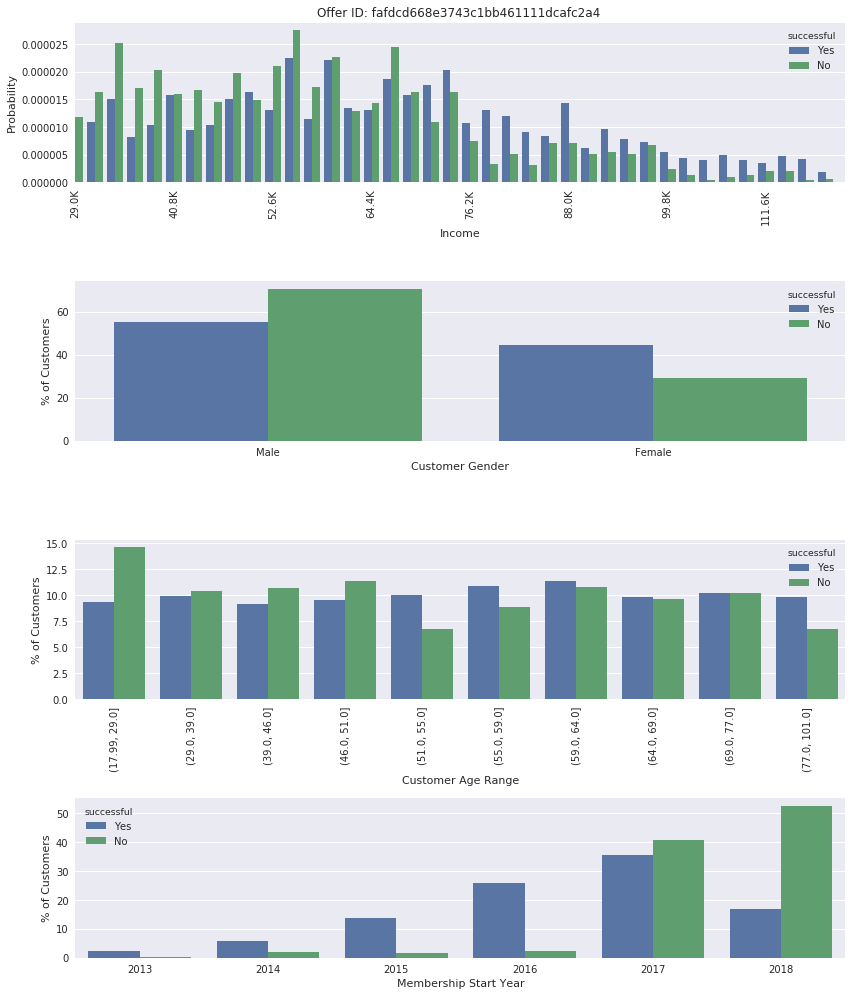

In [50]:
customer_offer_analytics(1, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 2
### Description
* Discount type offer where a customer has 7 days to spend \\$7 for which the reward is \\$3 off
* Offer was shown through email, mobile, social and web channels
* This offer had a 73.78% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$70,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers

offer_id              2298d6c36e964ae4a3e7e9706d1fb8c2
offer_successful                                  3886
total                                             5267
percentage_success                               73.78
min_spend_required                                   7
reward                                               3
duration_days                                        7
bogo                                                 0
discount                                             1
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         1
Name: 1, dtype: object


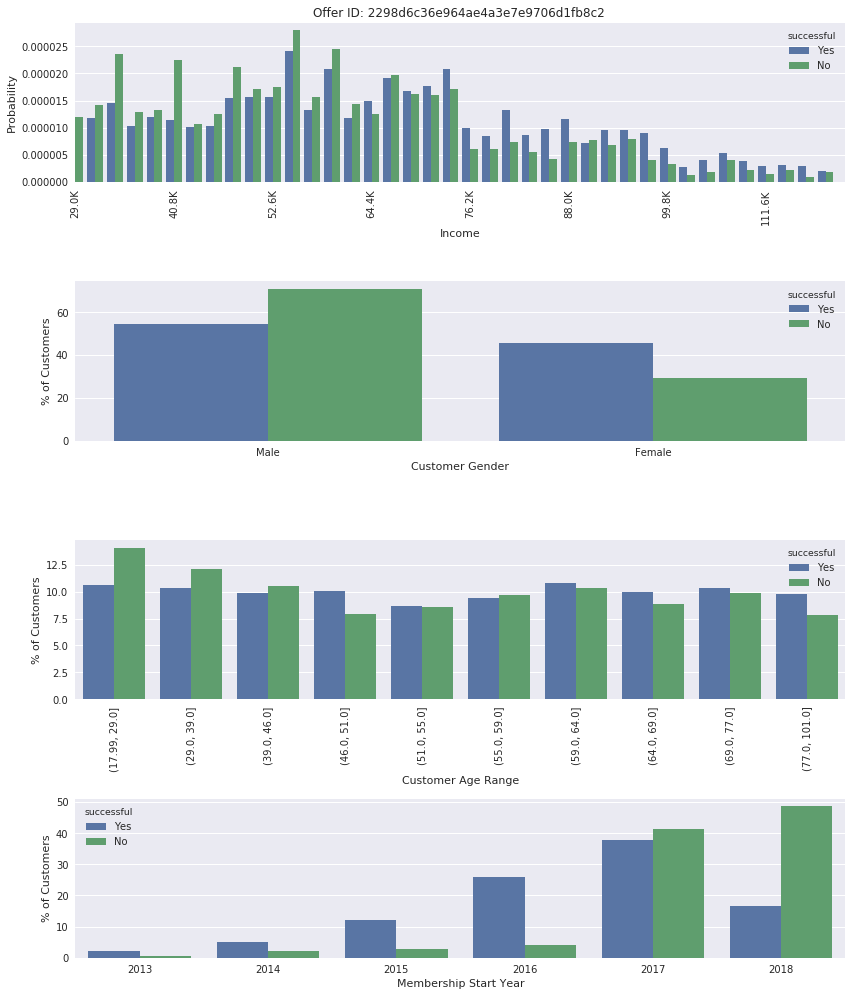

In [51]:
customer_offer_analytics(2, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 3
### Description
* BOGO type offer where a customer has 5 days to spend \\$5
* Offer was shown through email, mobile, social and web channels
* This offer had a 62.72% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$62,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers whereas customers who began in 2017 had roughly same number of successful/unsucessful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              f19421c1d4aa40978ebb69ca19b0e20d
offer_successful                                  3251
total                                             5183
percentage_success                               62.72
min_spend_required                                   5
reward                                               5
duration_days                                        5
bogo                                                 1
discount                                             0
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         1
Name: 2, dtype: object


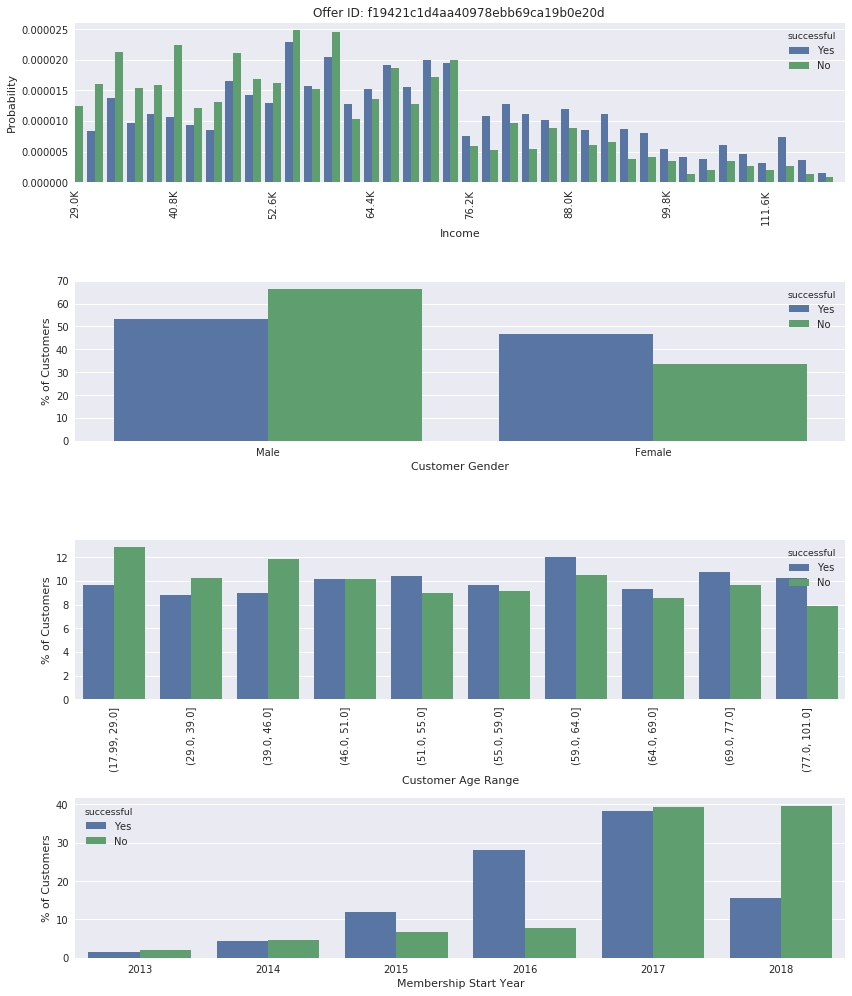

In [52]:
customer_offer_analytics(3, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 4
### Description
* BOGO type offer where a customer has 7 days to spend \\$5
* Offer was shown through email, mobile and web channels
* This offer had a 62.64% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$70,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers whereas customers who began in 2017 had roughly same number of successful/unsucessful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              9b98b8c7a33c4b65b9aebfe6a799e6d9
offer_successful                                  3280
total                                             5236
percentage_success                               62.64
min_spend_required                                   5
reward                                               5
duration_days                                        7
bogo                                                 1
discount                                             0
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      0
channels_web                                         1
Name: 3, dtype: object


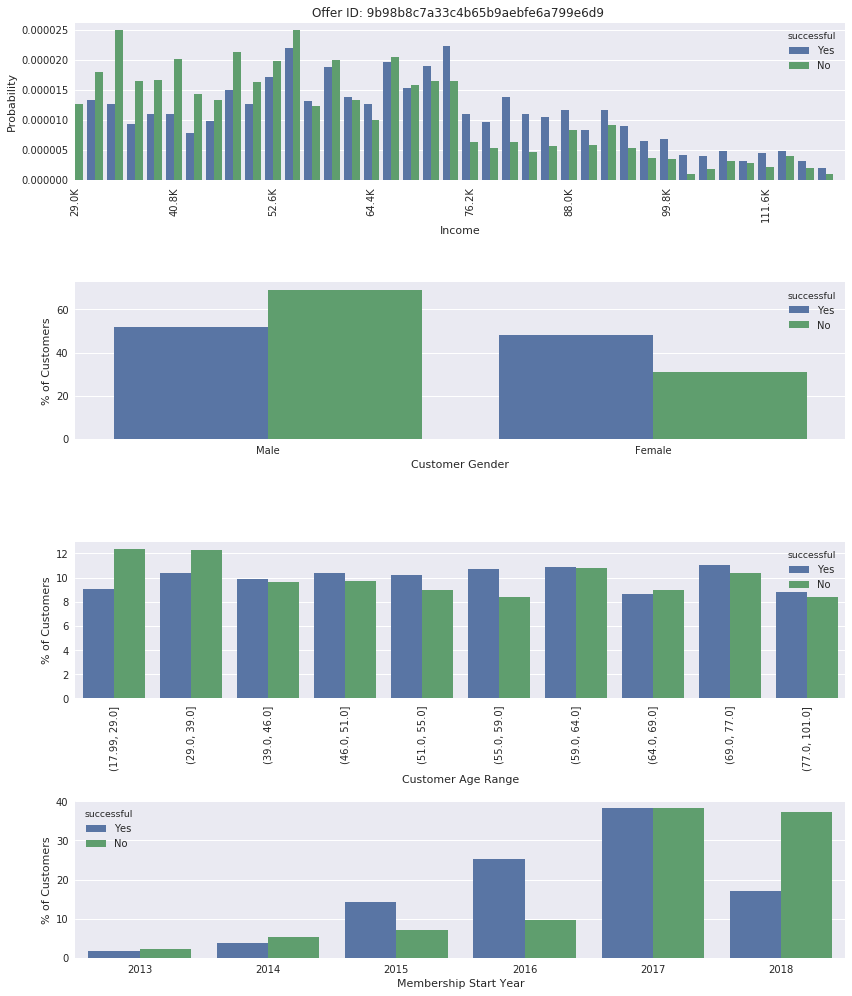

In [53]:
customer_offer_analytics(4, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 5
### Description
* Discount type offer where a customer has 7 days to spend \\$10 for which the reward is $2 off
* Offer was shown through email, mobile and web channels
* This offer had a 60.24% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$62,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first four age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers whereas customers who began in 2017 had roughly same number of successful/unsucessful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              2906b810c7d4411798c6938adc9daaa5
offer_successful                                  3155
total                                             5237
percentage_success                               60.24
min_spend_required                                  10
reward                                               2
duration_days                                        7
bogo                                                 0
discount                                             1
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      0
channels_web                                         1
Name: 4, dtype: object


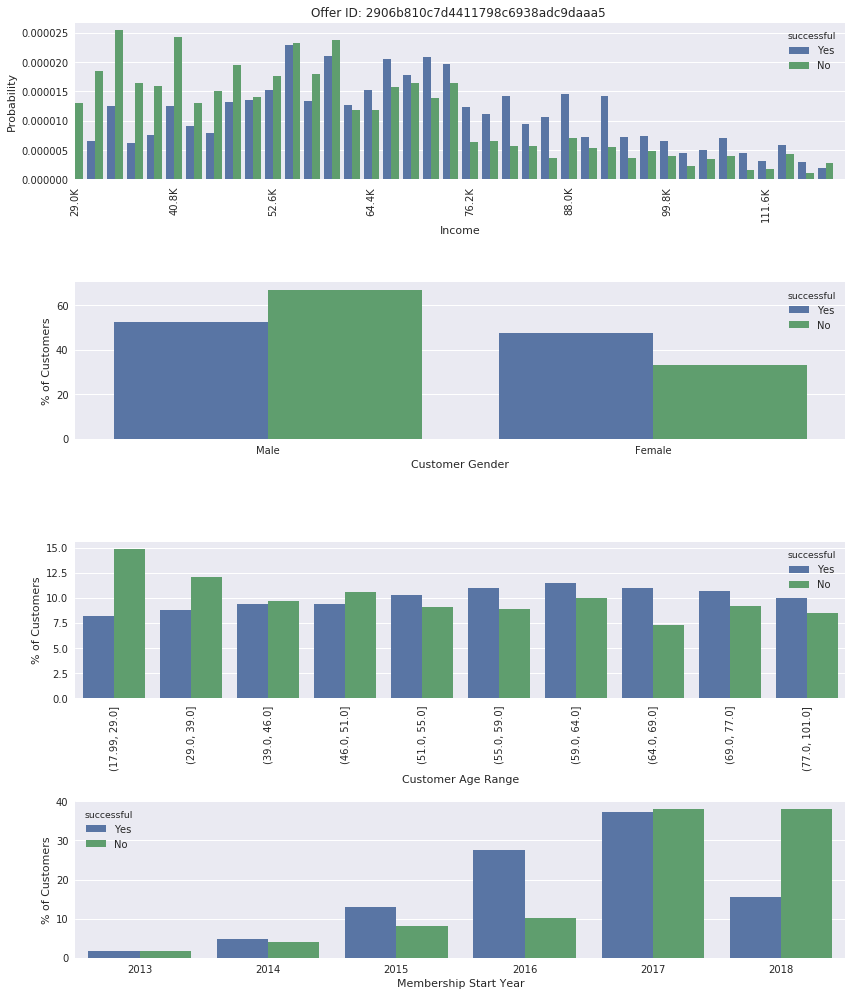

In [54]:
customer_offer_analytics(5, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 6
### Description
* BOGO type offer where a customer has 7 days to spend \\$10
* Offer was shown through email, mobile and social channels
* This offer had a 58.11% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$62,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers whereas customers who began in 2017 had roughly same number of successful/unsucessful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              ae264e3637204a6fb9bb56bc8210ddfd
offer_successful                                  3062
total                                             5269
percentage_success                               58.11
min_spend_required                                  10
reward                                              10
duration_days                                        7
bogo                                                 1
discount                                             0
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         0
Name: 5, dtype: object


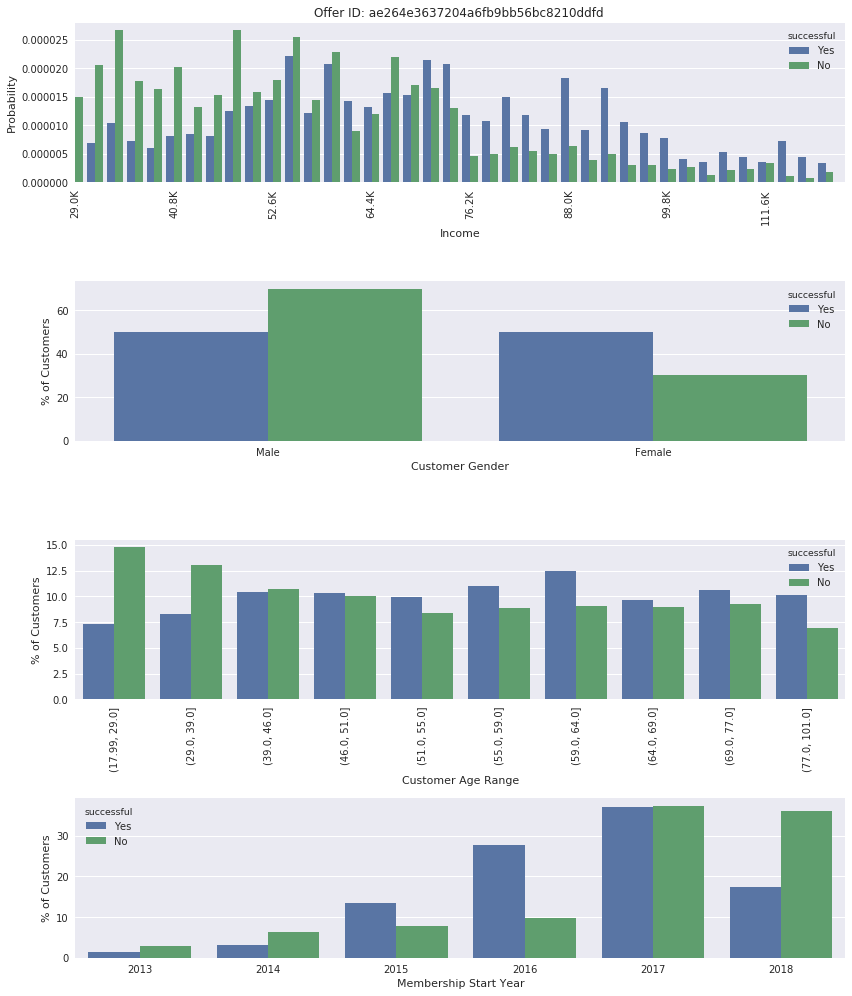

In [55]:
customer_offer_analytics(6, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 7
### Description
* Discount type offer where a customer has 10 days to spend \\$20 for which the reward is $5 off
* Offer was shown through email and web channels
* This offer had a 56.47% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$66,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers whereas customers who began in 2017 had roughly same number of successful/unsucessful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              0b1e1539f2cc45b7b9fa7c272da2e1d7
offer_successful                                  3014
total                                             5337
percentage_success                               56.47
min_spend_required                                  20
reward                                               5
duration_days                                       10
bogo                                                 0
discount                                             1
informational                                        0
channels_email                                       1
channels_mobile                                      0
channels_social                                      0
channels_web                                         1
Name: 6, dtype: object


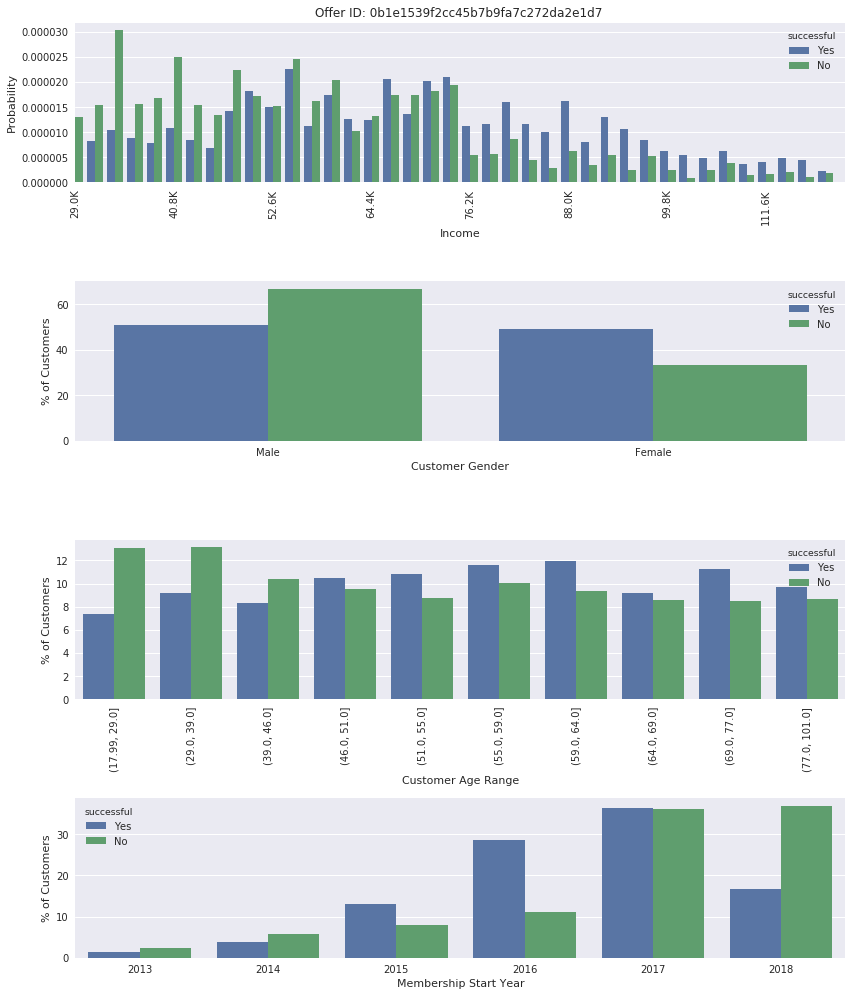

In [56]:
customer_offer_analytics(7, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 8
### Description
* BOGO type offer where a customer has 5 days to spend \\$10
* Offer was shown through email, mobile, social and web channels
* This offer had a 53.13% success rate 

### Observations
* Successful offers begin to outweigh unsucessful offers when income is greater than \\$68,000
* Males experienced more unsuccessful offers while females experienced more successful offers
* The first three age bins had more unsuccessful offers while the rest of the age bins had slightly higher successful offers
* Customers who began their membership in 2013 through 2017 experienced more successful offers. Customers who began in 2018 have drastically more unsuccessful offers than successful ones.

offer_id              4d5c57ea9a6940dd891ad53e9dbe8da0
offer_successful                                  2761
total                                             5197
percentage_success                               53.13
min_spend_required                                  10
reward                                              10
duration_days                                        5
bogo                                                 1
discount                                             0
informational                                        0
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         1
Name: 7, dtype: object


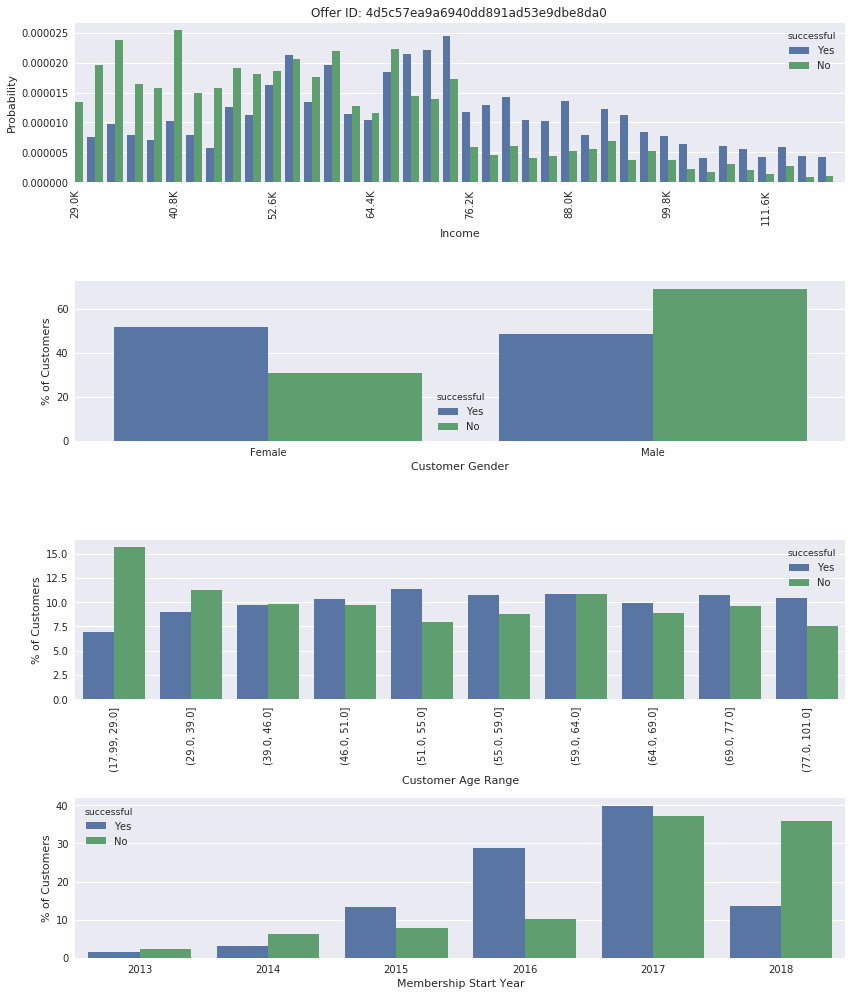

In [57]:
customer_offer_analytics(8, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 9
### Description
* Informational type offer with validity period of 4 days, which assume customer feels influence of offer for 4 days after receiving the advertisement
* Offer was shown through email, mobile and web channels
* This offer had a 11.08% success rate 

### Observations
* Males experienced slightly more unsuccessful offers while females experienced slightly more successful offers
* The 51-55 age bin and above generally had slightly higher successful offers
* Customers who began their membership in 2013 through 2016 experienced slightly more successful offers. Customers who began in 2017 and 2018 have slightly more unsuccessful offers than successful ones.

offer_id              3f207df678b143eea3cee63160fa8bed
offer_successful                                   587
total                                             5298
percentage_success                               11.08
min_spend_required                                   0
reward                                               0
duration_days                                        4
bogo                                                 0
discount                                             0
informational                                        1
channels_email                                       1
channels_mobile                                      1
channels_social                                      0
channels_web                                         1
Name: 8, dtype: object


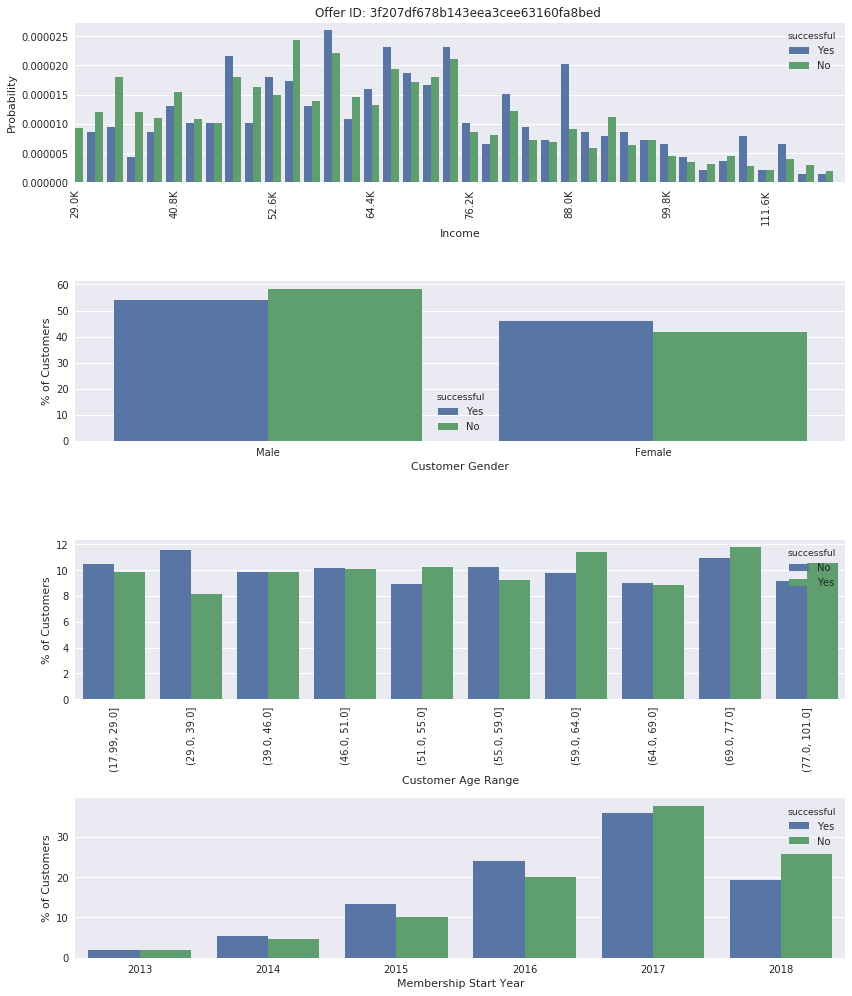

In [58]:
customer_offer_analytics(9, offer_id_success_rates, training_data)

## Customer Offer Visuals for Offer ID: 10
### Description
* Informational type offer with validity period of 3 days, which assume customer feels influence of offer for 3 days after receiving the advertisement
* Offer was shown through email, social and mobile channels
* This offer had a 7.55% success rate 

### Observations
* Males experienced slightly more unsuccessful offers while females experienced slightly more successful offers
* The 46-51 age bin through 69-77 age bin and above generally had slightly higher successful offers. Age bins 18-29, 29-39 and 77-101 had more unsuccessful offers
* Customers who began their membership in 2013 through 2016 experienced more successful offers. Customers who began in 2017 and 2018 have more unsuccessful offers than successful ones.

offer_id              5a8bc65990b245e5a138643cd4eb9837
offer_successful                                   394
total                                             5221
percentage_success                                7.55
min_spend_required                                   0
reward                                               0
duration_days                                        3
bogo                                                 0
discount                                             0
informational                                        1
channels_email                                       1
channels_mobile                                      1
channels_social                                      1
channels_web                                         0
Name: 9, dtype: object


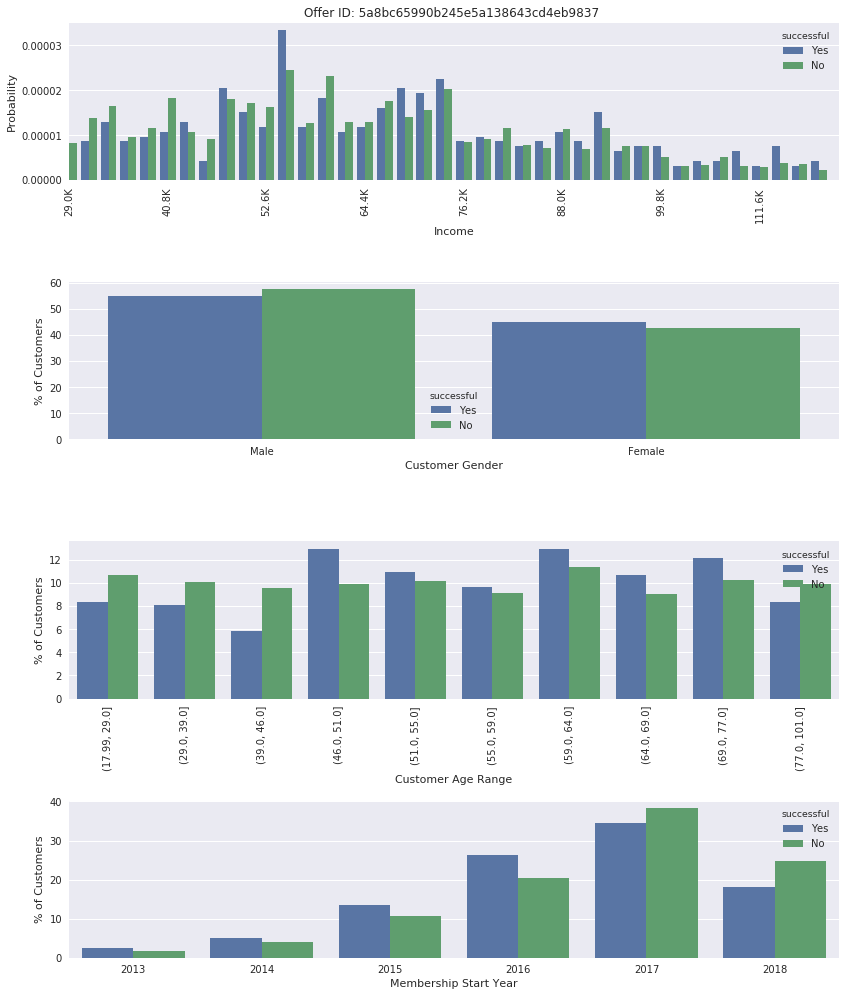

In [59]:
customer_offer_analytics(10, offer_id_success_rates, training_data)

## Overall General Trends
* Offer success increases with average customer income and age
* Male customers typically had higher percentage of unsuccessful offers while female customers had higher percentage of successful offers
* Offers were less successful for customers who began their membership in 2017 or 2018

# Step 6: Predictive Modeling and Evaluating Training Data Performance
Evaluate naive predictor model for which it assumes all customer offers are successful.

In [60]:
# Evaluate Naive Predictor Model Performance
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive Predictor Accuracy: %.2f" % round(naive_predictor_accuracy * 100, 2) + "%")
print("Naive Predictor F1 score: %.2f" % round(naive_predictor_f1score * 100, 2) + "%")

Naive Predictor Accuracy: 52.16%
Naive Predictor F1 score: 68.56%


##  Logistic Regression Model
Logistic Regression models the probability of a target variable that is binary, which in this case is when the offer is successful or not.

In [61]:
# Instantiate model
log_reg = LogisticRegression(random_state=42)

# Fit model
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
# Evaluate Logistic Regression Model Performance
log_reg_y_pred_class = log_reg.predict(X_train)

log_reg_predictor_accuracy = accuracy_score(y_train, log_reg_y_pred_class)
log_reg_predictor_f1score = f1_score(y_train, log_reg_y_pred_class)

print("Logistic Regression Accuracy: %.2f" % round(log_reg_predictor_accuracy * 100, 2) + "%")
print("Logistic Regression F1 score: %.2f" % round(log_reg_predictor_f1score * 100, 2) + "%")

Logistic Regression Accuracy: 66.66%
Logistic Regression F1 score: 74.04%


## Random Forest Classifier Model
A Random Forest Classifier Model consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest returns a class prediction and the class with the most votes becomes the model’s prediction. A large number of relatively uncorrelated models operating as a committee will outperform any of its individual model.

In [63]:
# Instantiate model
rf_clf = RandomForestClassifier(random_state=42)

# Fit model
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [64]:
# Evaluate Random Forest Model Performance
rf_clf_y_pred_class = rf_clf.predict(X_train)

rf_clf_predictor_accuracy = accuracy_score(y_train, rf_clf_y_pred_class)
rf_clf_predictor_f1score = f1_score(y_train, rf_clf_y_pred_class)

print("Random Forest Classifier Accuracy: %.2f" % round(rf_clf_predictor_accuracy * 100, 2) + "%")
print("Random Forest Classifier F1 score: %.2f" % round(rf_clf_predictor_f1score * 100, 2) + "%")

Random Forest Classifier Accuracy: 87.66%
Random Forest Classifier F1 score: 88.13%


## Gradient Boosting Classifier Model
Gradient Boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting. 

In [65]:
# Instantiate model
gb_clf = GradientBoostingClassifier(random_state=42)

# Fit model
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [66]:
# Evaluate Gradient Boosting Model Performance
gb_clf_y_pred_class = gb_clf.predict(X_train)

gb_clf_predictor_accuracy = accuracy_score(y_train, gb_clf_y_pred_class)
gb_clf_predictor_f1score = f1_score(y_train, gb_clf_y_pred_class)

print("Gradient Boosting Classifier Accuracy: %.2f" % round(gb_clf_predictor_accuracy * 100, 2) + "%")
print("Gradient Boosting Classifier F1 score: %.2f" % round(gb_clf_predictor_f1score * 100, 2) + "%")

Gradient Boosting Classifier Accuracy: 74.80%
Gradient Boosting Classifier F1 score: 76.92%


## Confusion Matrices and its Metrics
A Confusion Matrix is a performance measurement for machine learning classification problems. It is extremely useful for measuring Recall, Precision, Specificity, Accuracy and ROC Curve. 

In [67]:
# Logistic Regression Confusion Matrix
log_reg_confusion_matrix = confusion_matrix(y_train, log_reg_y_pred_class)
log_reg_TP = log_reg_confusion_matrix[1, 1]
log_reg_TN = log_reg_confusion_matrix[0, 0]
log_reg_FP = log_reg_confusion_matrix[0, 1]
log_reg_FN = log_reg_confusion_matrix[1, 0]

# Random Forest Confusion Matrix
rf_clf_confusion_matrix = confusion_matrix(y_train, rf_clf_y_pred_class)
rf_clf_TP = rf_clf_confusion_matrix[1, 1]
rf_clf_TN = rf_clf_confusion_matrix[0, 0]
rf_clf_FP = rf_clf_confusion_matrix[0, 1]
rf_clf_FN = rf_clf_confusion_matrix[1, 0]

# Gradient Boosting Confusion Matrix
gb_clf_confusion_matrix = confusion_matrix(y_train, gb_clf_y_pred_class)
gb_clf_TP = gb_clf_confusion_matrix[1, 1]
gb_clf_TN = gb_clf_confusion_matrix[0, 0]
gb_clf_FP = gb_clf_confusion_matrix[0, 1]
gb_clf_FN = gb_clf_confusion_matrix[1, 0]

print("Logistic Regression Confusion Matrix:")
print(log_reg_confusion_matrix)
print("Random Forest Classifier Confusion Matrix:")
print(rf_clf_confusion_matrix)
print("Gradient Boosting Classifier Confusion Matrix:")
print(gb_clf_confusion_matrix)

Logistic Regression Confusion Matrix:
[[10034 15068]
 [ 2423 24943]]
Random Forest Classifier Confusion Matrix:
[[21958  3144]
 [ 3332 24034]]
Gradient Boosting Classifier Confusion Matrix:
[[17209  7893]
 [ 5331 22035]]


### __Sensitivity__ 
* When the actual value is positive, how often is the prediction correct?
* Something to maximize
* How "sensitive" is the classifier to detecting positive instances?
* TP / (TP + FN)

In [68]:
log_reg_sensitivity = recall_score(y_train, log_reg_y_pred_class)
print("Logistic Regression Sensitivity: %.2f" % round(log_reg_sensitivity * 100, 2) + "%")
rf_clf_sensitivity = recall_score(y_train, rf_clf_y_pred_class)
print("Random Forest Classifier Sensitivity: %.2f" % round(rf_clf_sensitivity * 100, 2) + "%")
gb_clf_sensitivity = recall_score(y_train, gb_clf_y_pred_class)
print("Gradient Boosting Classifier Sensitivity: %.2f" % round(gb_clf_sensitivity * 100, 2) + "%")

Logistic Regression Sensitivity: 91.15%
Random Forest Classifier Sensitivity: 87.82%
Gradient Boosting Classifier Sensitivity: 80.52%


### __Specificity__ 
* When the actual value is negative, how often is the prediction correct?
* Something to maximize
* How "specific" (or "selective") is the classifier in predicting positive instances?
* TN / (TN + FP)

In [69]:
log_reg_specificity = log_reg_TN / (log_reg_TN + log_reg_FP)
print("Logistic Regression Specificity: %.2f" % round(log_reg_specificity * 100, 2) + "%")
rf_clf_specificity = rf_clf_TN / (rf_clf_TN + rf_clf_FP)
print("Random Forest Classifier Specificity: %.2f" % round(rf_clf_specificity * 100, 2) + "%")
gb_clf_specificity = gb_clf_TN / (gb_clf_TN + gb_clf_FP)
print("Gradient Boosting Classifier Specificity: %.2f" % round(gb_clf_specificity * 100, 2) + "%")

Logistic Regression Specificity: 39.97%
Random Forest Classifier Specificity: 87.48%
Gradient Boosting Classifier Specificity: 68.56%


### __Precision__ 
* When a positive value is predicted, how often is the prediction correct?
* How "precise" is the classifier when predicting positive instances?
* TP / (TP + FP)

In [70]:
log_reg_precision = precision_score(y_train, log_reg_y_pred_class)
print("Logistic Regression Precision: %.2f" % round(log_reg_precision * 100, 2) + "%")
rf_clf_precision = precision_score(y_train, rf_clf_y_pred_class)
print("Random Forest Classifier Precision: %.2f" % round(rf_clf_precision * 100, 2) + "%")
gb_clf_precision = precision_score(y_train, gb_clf_y_pred_class)
print("Gradient Boosting Classifier Precision: %.2f" % round(gb_clf_precision * 100, 2) + "%")

Logistic Regression Precision: 62.34%
Random Forest Classifier Precision: 88.43%
Gradient Boosting Classifier Precision: 73.63%


## Receiver Operating Characteristic (ROC) Curves
ROC curve is a plot of the true positive rate (Sensitivity) against the false positive rate (False alarm) for different cutpoints. An ideal graph will have its 'elbow' in the top left most corner as its sensitivity is 1.0 while its false positive rate is 0. 

Text(0,0.5,'True Positive Rate (Sensitivity)')

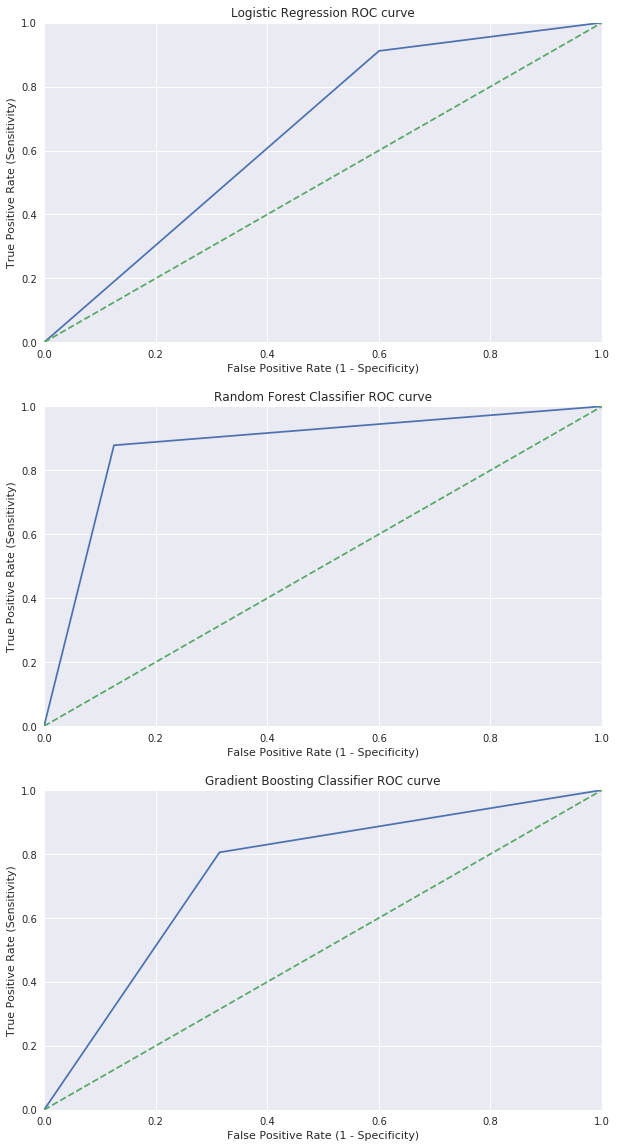

In [71]:
# Setup roc_curves for three models
log_reg_fpr, log_reg_tpr, log_reg_thresholds = roc_curve(y_train, log_reg_y_pred_class)
rf_clf_fpr, rf_clf_tpr, rf_clf_thresholds = roc_curve(y_train, rf_clf_y_pred_class)
gb_clf_fpr, gb_clf_tpr, gb_clf_thresholds = roc_curve(y_train, gb_clf_y_pred_class)

# Setup 3x1 Plot
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# Logistic Regression ROC curve
ax[0].plot(log_reg_fpr, log_reg_tpr)
ax[0].plot([0, 1], [0, 1], linestyle='dashed')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_title('Logistic Regression ROC curve')
ax[0].set_xlabel('False Positive Rate (1 - Specificity)')
ax[0].set_ylabel('True Positive Rate (Sensitivity)')

# Random Forest Classifier ROC curve
ax[1].plot(rf_clf_fpr, rf_clf_tpr)
ax[1].plot([0, 1], [0, 1], linestyle='dashed')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_title('Random Forest Classifier ROC curve')
ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
ax[1].set_ylabel('True Positive Rate (Sensitivity)')

# Gradient Boosting Classifier ROC curve
ax[2].plot(gb_clf_fpr, gb_clf_tpr)
ax[2].plot([0, 1], [0, 1], linestyle='dashed')
ax[2].set_xlim([0.0, 1.0])
ax[2].set_ylim([0.0, 1.0])
ax[2].set_title('Gradient Boosting Classifier ROC curve')
ax[2].set_xlabel('False Positive Rate (1 - Specificity)')
ax[2].set_ylabel('True Positive Rate (Sensitivity)')


## Model Performance Summary

In [72]:
# Instantiate variables
model_stats = []
model_type = ['Naive Predictor', 'Logistic Regression', 'Random Forest', 'Gradient Boosting']

# Append different model summary stats to list and create dataframe from it
model_stats.append((naive_predictor_accuracy, naive_predictor_f1score, 
                    np.nan, np.nan, np.nan))
model_stats.append((log_reg_predictor_accuracy, log_reg_predictor_f1score, 
                    log_reg_sensitivity, log_reg_specificity, log_reg_precision))
model_stats.append((rf_clf_predictor_accuracy, rf_clf_predictor_f1score, 
                    rf_clf_sensitivity, rf_clf_specificity, rf_clf_precision))
model_stats.append((gb_clf_predictor_accuracy, gb_clf_predictor_f1score, 
                    gb_clf_sensitivity, gb_clf_specificity, gb_clf_precision))
model_stats = pd.DataFrame(model_stats, columns=['Accuracy', 'F1 Score', 'Sensitivity', 'Specificity', 'Precision'])

# Create model_type df
model_type = pd.DataFrame(model_type, columns=['Model'])

# Create model_stats df by combinig model_type and model_stats df
model_stats = pd.concat([model_type, model_stats], axis=1)
model_stats = model_stats.sort_values('Accuracy', ascending=False)
model_stats['Accuracy'] = pd.Series(["{0:.2f}%".format(val * 100) for val in model_stats['Accuracy']], 
                                    index = model_stats.index)
model_stats['F1 Score'] = pd.Series(["{0:.2f}%".format(val * 100) for val in model_stats['F1 Score']], 
                                    index = model_stats.index)
model_stats['Sensitivity'] = pd.Series(["{0:.2f}%".format(val * 100) for val in model_stats[0:3]['Sensitivity']], 
                                    index = model_stats.index[0:3])
model_stats['Specificity'] = pd.Series(["{0:.2f}%".format(val * 100) for val in model_stats[0:3]['Specificity']], 
                                    index = model_stats.index[0:3])
model_stats['Precision'] = pd.Series(["{0:.2f}%".format(val * 100) for val in model_stats[0:3]['Precision']], 
                                    index = model_stats.index[0:3])
model_stats.set_index('Model')

,Accuracy,F1 Score,Sensitivity,Specificity,Precision
Model,,,,,
Random Forest,87.66%,88.13%,87.82%,87.48%,88.43%
Gradient Boosting,74.80%,76.92%,80.52%,68.56%,73.63%
Logistic Regression,66.66%,74.04%,91.15%,39.97%,62.34%
Naive Predictor,52.16%,68.56%,NaN,NaN,NaN


Based from the dataframe above, the Random Forest model provides the best numbers across the various metrics. Additionally, the Random Forest model's ROC curve is the best as its 'elbow' is closest to the top left corner of the graph. An interesting observation is the Logistic Regression's low specificity metric which indicates that when an offer wasn't successful, the model predicted that roughly 40% of the time correctly. 

## Plotting Estimated Feature Importance
Feature Importance are numerical values that illustrate a feature's importance to building a model with regards to its evaluation metric. Given how the Random Forest was the best performing model based off the training data, below are the top five features for the model.
<ol>
    <li>income</li>
    <li>duration_days</li>
    <li>informational</li>
    <li>min_spend_required</li>
    <li>start_year_2018</li>
</ol>

Text(0.5,1,'Random Forest Classifier Estimated Feature Importance')

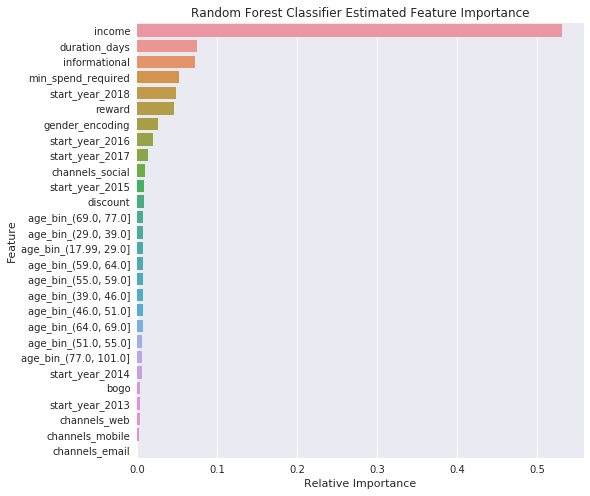

In [73]:
relative_importances = rf_clf.feature_importances_
relative_importances = relative_importances / np.sum(relative_importances)

feature_importances = pd.DataFrame(relative_importances, 
                                   index=column_ordering, 
                                   columns=['relative_importances']).sort_values('relative_importances', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(8, 8))
sns.barplot(x='relative_importances', y=feature_importances.index, data=feature_importances)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Classifier Estimated Feature Importance')

# Step 7: Tune Best Training Model and Evaluate Model on Test Data
Hyperparameter tuning is choosing an optimal set of parameters used for a learning algorithm. It relies more on experimentation than theory and thus the best method to determine the optimal settings is trying many different combinations. Evaluating a model only on the training set can lead to one of the most fundamental problems in machine learning, which is overfitting.

In [74]:
# Identify parameters currently in use by Random Forest Classifier
print('Parameters currently in use:')
print(rf_clf.get_params())

Parameters currently in use:
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


The most important settings are the number of trees in the forest (n_estimators: 10) and the number of features considered for splitting at each leaf node (max_features: 'auto'). 

In [75]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create parameter_grid
parameter_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

print(parameter_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Using RandomizedSearchCV, hyperparameter settings are defined and randomly sampled from the grid while performing K-Fold cross validation on each combination of values.

The most important arguments in RandomizedSearchCV are:
* n_iter (100) - determines the number of different combinations to try
* cv (3) - the number of folds to use for cross validation; this is used to combat overfitting

The more iterations means a wider search space while more cv folds reduces the chances of overfitting.

In [76]:
# Create models directory
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [77]:
random_search_path = os.path.join(model_dir, 'random_search.joblib')

# If RandomizedSearchCV fit object already exists, load it. Otherwise perform RandomizedSearchCV
if os.path.exists(random_search_path):
    random_search_fit = joblib.load(random_search_path)
else:
    # Random search of parameters, using 3 fold cross validation
    # Search across 100 different combinations, and use all available cores
    rf_random_search = RandomizedSearchCV(estimator = rf_clf, 
                                          param_distributions = parameter_grid, 
                                          n_iter = 100, 
                                          cv = 3, 
                                          verbose = 2, 
                                          random_state = 42, 
                                          n_jobs = -1)

    # Fit the random search model
    start = time()
    random_search_fit = rf_random_search.fit(X_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), 100))

    joblib.dump(random_search_fit, random_search_path, compress = 1)

In [78]:
# Print best parameters from fitting random search
random_search_fit.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

## Evaluate Test Data Performance

In [79]:
# Evaluate Random Forest Model Performance with RandomizedSearch tuning in consideration
rf_clf_y_pred_class = random_search_fit.predict(X_test)

rf_clf_predictor_accuracy = accuracy_score(y_test, rf_clf_y_pred_class)
rf_clf_predictor_f1score = f1_score(y_test, rf_clf_y_pred_class)

print("Random Forest Classifier Accuracy: %.2f" % round(rf_clf_predictor_accuracy * 100, 2) + "%")
print("Random Forest Classifier F1 score: %.2f" % round(rf_clf_predictor_f1score * 100, 2) + "%")

Random Forest Classifier Accuracy: 74.57%
Random Forest Classifier F1 score: 76.86%


# Conclusion

From this project, the problem I wanted to solve was building a model that predicts whether a customer responded successfully to an offer. My plan to achieve this problem contained the following steps:

* Pre-process offer portfolio, customer profile, and transaction data and aggregate them into combined dataset
* Split the combined dataset into training/testing data
* Perform data analysis and visualizations for each offer type to gain customer insight
* Train various classification models and compare model performances 
* Tune best performing training model and evaluate model on test data

The analysis from the training model step indicated that the Random Forest model had the best training data accuracy and F1 score with values of 87.66% and 88.13% respectively. The last step involved optimizing a set of the model's hyperparameters using a RandomizedSearch. Using the best parameters obtained from the tuning process, the test data accuracy and F1 score had values of 74.57% and 76.86% respectively. These numbers indicate that the model did not overfit the training data.

From the Feature Importance step, the top five features from the Random Forest model with the training data were:
<ol>
    <li>Income</li>
    <li>Offer Duration</li>
    <li>Informational Offer Type</li>
    <li>Required Minimum Spend</li>
    <li>Customers who created an account in 2018</li>
</ol>

Given how the income as well as the offer duration and how much money a customer must spend to complete an offer are in the list above, it may be possible to improve the Random Forest model's performance. One way to do so is by  incorporating new features that illustrate an offer's success rate, taking into account a customer's income, the offer duration and the required minimum spend.

# References
Starbucks Capstone Challenge Github repo: https://github.com/mspcvsp/StarbucksCapstoneChallenge<br>
The What, Why & How of the 360-Degree Customer View: https://digitalmarketinginstitute.com/en-us/blog/the-what-why-and-how-of-360-degree-customer-view<br>
MultiLabelBinarizer: https://www.kaggle.com/questions-and-answers/66693<br>
Pandas get_dummies function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html<br>
Seaborn Tutorial: https://seaborn.pydata.org/tutorial.html<br>
Progress Bar documentation: https://progressbar-2.readthedocs.io/en/latest/#<br>
Train/Test Split: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6<br>
Random State in Splitting Dataset: https://stackoverflow.com/questions/42191717/python-random-state-in-splitting-dataset<br>
Feature Scaling: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html<br>
Scikit-learn MinMaxScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html<br>
Numpy "-1" reshape: https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape<br>
Reverse one-hot-encoding: https://stackoverflow.com/questions/38334296/reversing-one-hot-encoding-in-pandas<br>
Custom sorting pandas df: https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe<br>
Machine Learning Evaulate Classification Model: https://www.ritchieng.com/machine-learning-evaluate-classification-model/<br>
Logistic Regression Detailed Overview: https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc<br>
Understanding Random Forest: https://towardsdatascience.com/understanding-random-forest-58381e0602d2<br>
Random Forest Classifier Example: https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/<br>
Understanding Gradient Boosting Machines: https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab<br>
Understanding Confusion Matrix: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62<br>
Receiver Operating Characteristics (ROC): https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5<br>
Hyperparameter Tuning Random Forest: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74<br>
How to Save a Model: https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli<br>